In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from xgboost import XGBClassifier, plot_tree

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import ipywidgets as widgets
from ipywidgets import Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider

from IPython.display import Markdown, display

%matplotlib inline 


## Load Data

In [2]:
#dict for dtypes
dtypes = {'age':'int64', 'sex':'category','cp':'category','trestbps':'int64',
          'chol':'int64' ,'restecg':'category','thalach':'int64', 'exang':'category',
          'oldpeak':'float64', 'slope':'category','ca':'category','target':'int64', 'fbs':'category', 'thal':'category' }

df_data_raw = pd.read_csv('/data/heart.csv',dtype=dtypes)

## Data Cleaning and Exploratory Data Analysis

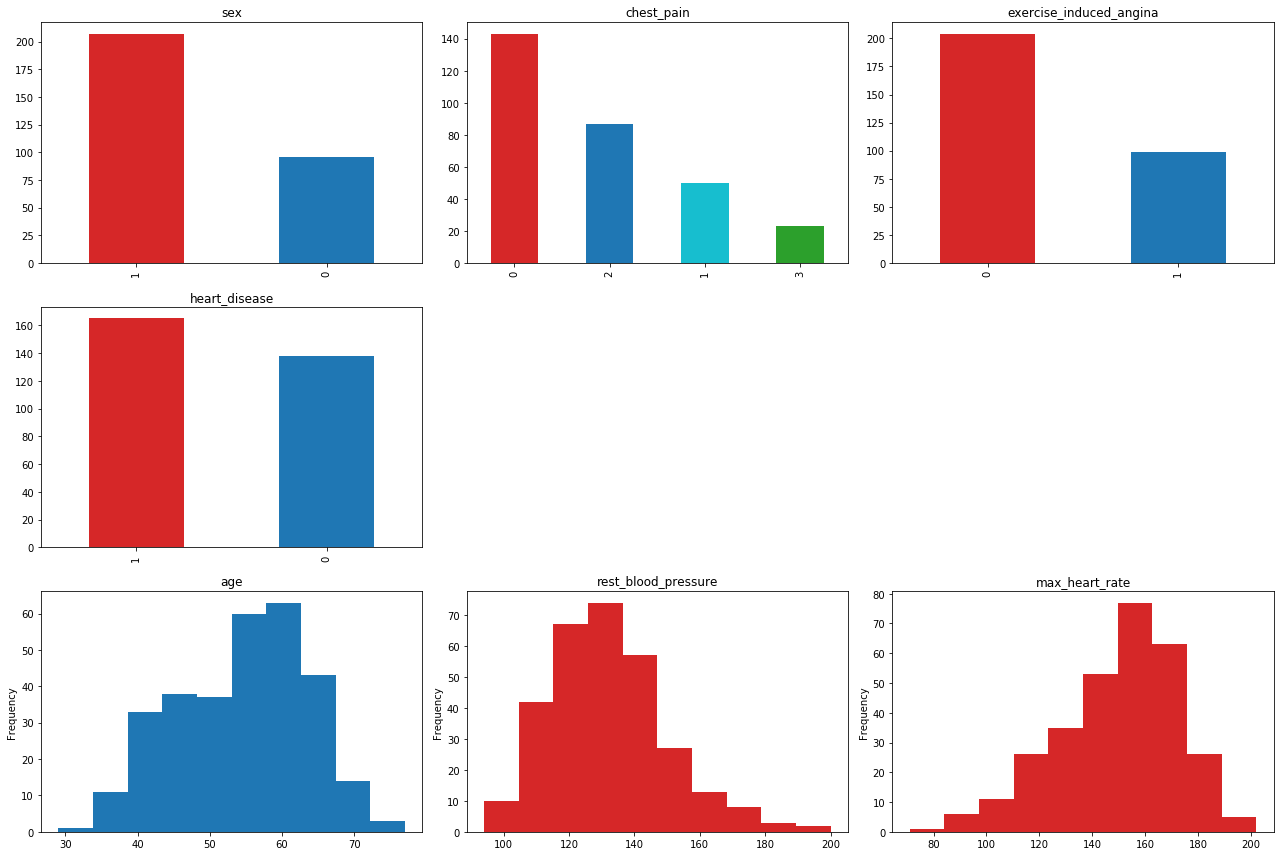

In [3]:
#rename columns
rename_col = {'cp':'chest_pain',
              'trestbps':'rest_blood_pressure',
              'chol':'serum_cholesterol',
              'fbs':'fast_blood_sugar>120mg/dl',
              'restecg':'resting_ecg',
              'thalach':'max_heart_rate',
            'exang':'exercise_induced_angina',
             'slope':'slope_ST',
              'ca':'nr_major_vessels',
              'target':'heart_disease'}

df_data_raw.rename(rename_col,axis='columns', inplace=True)
df_data = df_data_raw

fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(18,12))


df_data['sex'].value_counts().plot(kind='bar', color=['tab:red', 'tab:blue'],ax=axes[0,0], title='sex')
df_data['chest_pain'].value_counts().plot(kind='bar', color=['tab:red', 'tab:blue', 'tab:cyan', 'tab:green'], ax=axes[0,1], title='chest_pain')
df_data['exercise_induced_angina'].value_counts().plot(kind='bar', color=['tab:red', 'tab:blue'],ax=axes[0,2], title='exercise_induced_angina')
df_data['heart_disease'].value_counts().plot(kind='bar', color=['tab:red', 'tab:blue'],ax=axes[1,0], title='heart_disease')


df_data['age'].plot(kind='hist',title='age', color='tab:blue',ax=axes[2,0])
df_data['rest_blood_pressure'].plot(kind='hist',title='rest_blood_pressure', color='tab:red', ax=axes[2,1])
df_data['max_heart_rate'].plot(kind='hist',title='max_heart_rate', color='tab:red', ax=axes[2,2])


plt.tight_layout()

fig.delaxes(axes[1][1])
fig.delaxes(axes[1][2])

## Data Wrangling

In [4]:
#rearrange df
df_data = df_data[['sex','age','chest_pain','rest_blood_pressure', 'max_heart_rate', 'exercise_induced_angina',
                   'heart_disease'  ]]
#input variables X
X = df_data[['sex','age','chest_pain','rest_blood_pressure', 'max_heart_rate', 'exercise_induced_angina']]
#output variable y
y = df_data['heart_disease']

## Data Preparation

In [5]:
categorial = df_data[['sex','chest_pain',
                    'exercise_induced_angina']].values

#onehotencode categorical data
def onehotencode(categorial_data):
    encoded_X = None
    for i in range(0, categorial_data.shape[1]):
        label_encoder = LabelEncoder()
        feature = label_encoder.fit_transform(categorial_data[:,i])
        feature = feature.reshape(categorial_data.shape[0], 1)
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
        feature = onehot_encoder.fit_transform(feature)
        #add feature to encoded_X
        if encoded_X is None:
            encoded_X = feature
        else:
            encoded_X = np.concatenate((encoded_X, feature), axis=1)
    return encoded_X

encoded_X = onehotencode(categorial)


#add int and float data
numeric_cols = ['age', 'rest_blood_pressure', 'max_heart_rate']
for col in numeric_cols:
    values = X[col].values
    values = values.reshape(values.shape[0],1)
    encoded_X = np.concatenate((encoded_X, values), axis=1)
    
#reshape output variables
reshaped_y = y.values
reshaped_y = reshaped_y.reshape(y.shape[0],) 
     
#split train and test data
X_train, X_test, y_train, y_test = train_test_split(encoded_X, reshaped_y, test_size = 0.25, random_state=42)

## Grid Search

In [6]:
#grid search

# A parameter grid for XGBoost
params = {
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'min_child_weight': [1, 5, 10],
        'gamma': [1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators' : [100, 200, 300, 400, 500, 600, 700, 800]
        }

xgb = XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1)

folds = 5
param_comb = 7776

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# Here we go
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 tasks      | elapsed:    0.8s
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/backend/utils.py:55: UserWarning: Failed to kill subprocesses on this platform. Pleaseinstall psutil: https://github.com/giampaolo/psutil
  warnings.warn("Failed to kill subprocesses on this platform. Please"
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/backend/utils.py:55: UserWarning: Failed to kill subprocesses on this platform. Pleaseinstall psutil: https://github.com/giampaolo/psutil
  warnings.warn("Failed to kill subprocesses on this platform. Please"
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/backend/utils.py:55: UserWarning: Failed to kill subprocesses on this platform. Pleaseinstall psutil: https://github.com/giampaolo/psutil
  warnings.warn("Failed to kill subprocesses on this platform. Please"
/opt/conda/lib/python3.7/site-packages/joblib/external

KeyboardInterrupt: 

In [6]:
'''
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)

#get best hyperparameters
subsample = random_search.best_params_['subsample']
min_child_weight = random_search.best_params_['min_child_weight']
max_depth = random_search.best_params_['max_depth']
learning_rate = random_search.best_params_['learning_rate']
gamma = random_search.best_params_['gamma']
colsample_bytree = random_search.best_params_['colsample_bytree']
n_estimators = random_search.best_params_['n_estimators']
'''
#best hyperparameters for 6 variables
subsample = 0.8
min_child_weight = 5
max_depth = 3
learning_rate = 0.3
gamma = 5
colsample_bytree = 0.8
n_estimators = 200


## Run Model with best hyperparameters

In [7]:
eval_set =[(X_train, y_train), (X_test, y_test)]

#fit model
model = XGBClassifier(subsample=subsample, 
                      min_child_weight=min_child_weight, 
                      max_depth=max_depth, 
                      learning_rate=learning_rate, 
                      gamma=gamma, 
                      colsample_bytree=colsample_bytree,
                      n_estimators=n_estimators)
model.fit(X_train, y_train,early_stopping_rounds=10, eval_metric=['error', 'logloss'], eval_set=eval_set, verbose=False) 
#print(model)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.89%


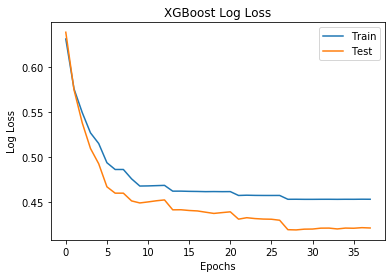

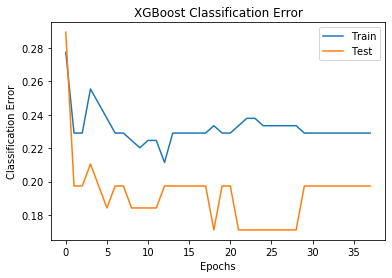

In [8]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Epochs')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.xlabel('Epochs')
plt.show()

## Feature Importance

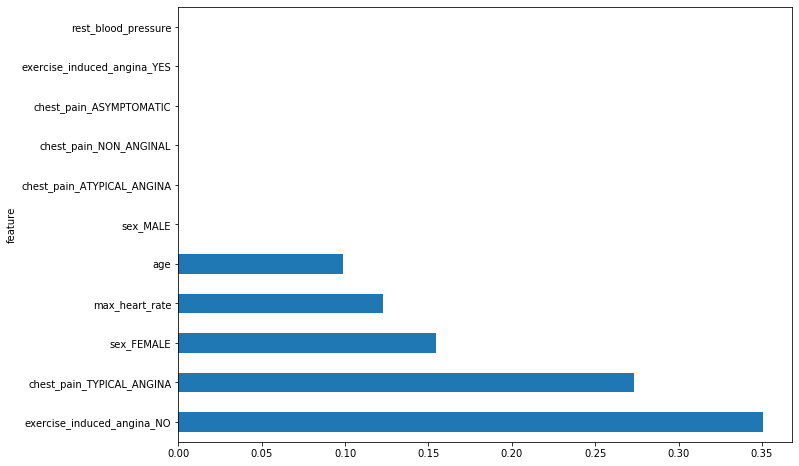

In [9]:
#encoded_X col labels:  
labels = ['sex_FEMALE', 'sex_MALE', 'chest_pain_TYPICAL_ANGINA','chest_pain_ATYPICAL_ANGINA','chest_pain_NON_ANGINAL','chest_pain_ASYMPTOMATIC',
         'exercise_induced_angina_NO', 'exercise_induced_angina_YES',
         'age', 'rest_blood_pressure', 'max_heart_rate' ]  

df_enc = pd.DataFrame(encoded_X)
df_enc.columns = labels

def feature_imp(df,model):
    fi = pd.DataFrame()
    fi["feature"] = df.columns
    fi["importance"] = model.feature_importances_
    return fi.sort_values(by="importance", ascending=False)

feature_imp(df_enc ,model).plot('feature', 'importance', kind='barh', figsize=(11,8), legend=False)

## Receiver Operator Characteristic (ROC)

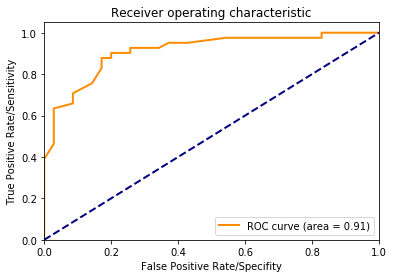

In [10]:
#calc false positve rate and true positive rate
y_predi = model.fit(X_train, y_train).predict_proba(X_test)[:,1] 
fpr, tpr, _ = roc_curve(y_test, y_predi)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate/Specifity')
plt.ylabel('True Positive Rate/Sensitivity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Predict whether or not you suffer from heart disease

In [11]:
style = {'description_width': 'initial'}

sex = widgets.Dropdown(
    options=['male', 'female'],
    style=style,
    description='sex'
)

chest_pain = widgets.Dropdown(
    options=['typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic'],
    style=style,
    description='chest pain type'
)

ex_ind_angina = widgets.Dropdown(
    options=['yes', 'no'],
    style=style,
    description='exercise induced angina'
)

age = widgets.Dropdown(
    options=[i for i in range(1,120)],
    style=style,
    description='age [years]'
)

rest_blood_pressure = widgets.Dropdown(
    options=[i for i in range(70,220)],
    style=style,
    description='resting blood pressure (systolic) [mm Hg]'
)

max_hr = widgets.Dropdown(
    options=[i for i in range(50,250)],
    style=style,
    description='max heart rate during exercise [beats/min]',

)

def convert(result):
    return {
        'female': [1,0],
        'male': [0,1],
        'typical angina': [1,0,0,0],
        'atypical angina': [0,1,0,0],
        'non-anginal pain': [0,0,1,0],
        'asymptomatic': [0,0,0,1],
        'yes': [1,0],
        'no': [0,1]
    }[result]

def printmd(string):
    display(Markdown(string))

def f(sex, chest_pain,ex_ind_angina, age, rest_blood_pressure, max_hr):
    topredict = []
    topredict = convert(sex)+ convert(chest_pain) + convert(ex_ind_angina)
    topredict.append(age)
    topredict.append(rest_blood_pressure)
    topredict.append(max_hr)
    to_predict = np.asarray(topredict)
    to_predict = to_predict.reshape(1, to_predict.shape[0])
    y_predict = model.predict(to_predict)
    predicted = [round(value) for value in y_predict]
    acc_test = ''
    if 0.9 <= roc_auc <= 1: 
        acc_test = 'excellent (A)'
    elif 0.8 <= roc_auc < 0.9: 
        acc_test = 'good (B)'
    elif 0.7 <= roc_auc < 0.8: 
        acc_test = 'fair (C)'
    elif 0.6 <= roc_auc < 0.7: 
        acc_test = 'poor (D)'
    elif 0.5 <= roc_auc < 0.6: 
        acc_test = 'fail (F)'
           
    if predicted[0] == 0:
        printmd('<span style="color:green">You likely have no heart disease</span>')
        print(f"Accuracy of this model: {format(accuracy, '.2f')}%")
        print(f'Accuracy of this test*: {acc_test}\n')

    else:
        printmd('<span style="color:red">You likely have a heart disease. Please visit a physician!</span>')
        print(f"Accuracy of this model: {format(accuracy, '.2f')}%")
        print(f'Accuracy of this test*: {acc_test}\n')
        
    print('*how well can this test discriminate between disease yes/no in its prediction')    
    print('Scale for accuracy of this test:')
    print('roc_auc between 0.9-1.0: excellent (A)')
    print('roc_auc between 0.8-0.9: good (B)')
    print('roc_auc between 0.7-0.8: fair (C)')
    print('roc_auc between 0.6-0.7: poor (D)')
    print('roc_auc between 0.5-0.6: fail (F)')

              
widgets.interact_manual(f, sex=sex, chest_pain=chest_pain,ex_ind_angina=ex_ind_angina, age=age, rest_blood_pressure=rest_blood_pressure, max_hr=max_hr)

interactive(children=(Dropdown(description='sex', options=('male', 'female'), style=DescriptionStyle(descripti…

<function __main__.f(sex, chest_pain, ex_ind_angina, age, rest_blood_pressure, max_hr)>